<small><i>This notebook was created by [Sergey Tomin](http://www.xfel.eu/organization/staff/tomin_sergey/) for Workshop: [Designing future X-ray FELs](http://www.xrayfels.co.uk/). Source and license info is on [GitHub](https://github.com/iagapov/ocelot/tree/dev/docs). August 2016. </i></small>

# An Introduction to Ocelot: Beam dynamics
## Outline
* Preliminaries: Setup & introduction
* What is Ocelot?
* Tutorial N1. Double Bend Achromat.
    - Linear optics.
* Tutorial N2. The European XFEL Injector.
    - Linear optics
    - Tracking. First and second order. 
* Tutorial N3. Chirper.
    - Tracking with Wakefieds
* Tutorial N4. Space Charge.
    - Tracking with SC effects.
* Interface to [Genesis](http://genesis.web.psi.ch/)

## Preliminaries
##### This tutorial requires the following packages:

- Python version 2.7 or 3.4-3.5
- `numpy` version 1.8 or later: http://www.numpy.org/
- `scipy` version 0.15 or later: http://www.scipy.org/
- `matplotlib` version 1.5 or later: http://matplotlib.org/
- `ipython` version 2.4 or later, with notebook support: http://ipython.org

The easiest way to get these is to download and install the (very large) [Anaconda software distribution](https://www.continuum.io/).

Alternatively, you can download and install [miniconda](http://conda.pydata.org/miniconda.html).
The following command will install all required packages:
```
$ conda install numpy scipy matplotlib ipython-notebook
```

##### Ocelot installation
1. you have to download from GitHub [zip file](https://github.com/iagapov/ocelot/archive/dev.zip). 
2. Unzip ocelot-dev.zip to your working folder **../your_working_dir/**. 
3. Rename folder **../your_working_dir/ocelot-dev** to **../your_working_dir/ocelot**. 
4. Add PYTHONPATH to **../your_working_dir/**

### Checking your installation

You can run the following code to check the versions of the packages on your system:

(in IPython notebook, press `shift` and `return` together to execute the contents of a cell)

In [1]:
from __future__ import print_function

import IPython
print('IPython:', IPython.__version__)

import numpy
print('numpy:', numpy.__version__)

import scipy
print('scipy:', scipy.__version__)

import matplotlib
print('matplotlib:', matplotlib.__version__)

import ocelot
print('ocelot:', ocelot.__version__)

IPython: 4.1.2
numpy: 1.10.4
scipy: 0.17.0
matplotlib: 1.5.1
initializing ocelot...
ocelot: 16.7.dev


## What is Ocelot?

Ocelot is a multiphysics simulation toolkit designed for studying FEL and storage ring based light sources. Ocelot is written in Python. Its central concept is the writing of python's scripts for simulations with the usage of Ocelot's modules and functions and the standard Python libraries. 

Ocelot includes following main modules:
* **Charge particle beam dynamics module (CPBD)**
    - optics
    - tracking
    - matching
    - collective effects
        - Space Charge (true 3D Laplace solver) 
        - CSR (Cogerent Synchrotron Radiation) (1D model with arbitrary number of dipole) (not tested).
        - Wakefields (Taylor expansion up to second order for arbitrary geometry).
    - MOGA (Multi Objective Genetics Algorithm). (in testing mode)
* **Native module for spontaneous radiation calculation**
* **FEL calculations: interface to GENESIS and pre/post-processing**
* **Module for online optimization of accelerator performances.** In development mode.

Using these blocks like a constructor (and python like a glue) we can construct a physical model or process for the simulation. In practice, it means flexibility and fast development. 

Ocelot extensively  uses Python's [NumPy (Numerical Python)](http://numpy.org) and [SciPy (Scientific Python)](http://scipy.org) libraries, which enable efficient in-core numerical and scientific computation within Python and give you access to various mathematical and optimization techniques and algorithms. To produce high quality figures Python's [matplotlib](http://matplotlib.org/index.html) library is used.

It is an open source project and it is being developed by physicists from  [XFEL](http://www.xfel.eu/), [DESY](http://www.desy.de/), [NRC KI](http://www.nrcki.ru/).

## Tutorial N1. Double Bend Achromat.

This tutorial introduces the reader informally to the basic concepts and syntax of Ocelot.

In [2]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline

In [3]:
# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

In [4]:
# Creating simple cell

# you can play with element parameters 

# defining of the drifts
D1 = Drift(l=2.)
D2 = Drift(l=0.6)
D3 = Drift(l=0.3)
D4 = Drift(l=0.7)
D5 = Drift(l=0.9)
D6 = Drift(l=0.2)

# defining of the quads
Q1 = Quadrupole(l= 0.4, k1=-1.3)
Q2 = Quadrupole(l= 0.8, k1=1.4)
Q3 = Quadrupole(l= 0.4, k1=-1.7)
Q4 = Quadrupole(l= 0.5, k1=1.3)

# defining of the bending magnet
B = Bend(l=2.7, k1=-.06, angle=2*pi/16., e1=pi/16., e2=pi/16.)

# defining of the sextupoles
SF = Sextupole(l=0.01, k2 = 1.5) #random value
SD = Sextupole(l=0.01, k2 = -1.5) #random value

# creating of the cell
cell = (D1, Q1, D2, Q2, D3, Q3, D4, B, D5, SD, D5, SF, D6, Q4,
        D6, SF, D5, SD,D5, B, D4, Q3, D3, Q2, D2, Q1, D1)

*hint: to see a simple description of the function put cursor inside () and press **Shift-Tab** or you can type sign **?** before function. To extend dialog window press **+** *

The cell is a list of the simple objects which contain a physical information of lattice elements such as length, strength, voltage and so on. In order to create a transport map for every element and bind it with lattice object we have to create new Ocelot object - MagneticLattice() which makes these things automatically. 

MagneticLattice(sequence, start=None, stop=None, method=MethodTM()) have wollowing arguments:     
* sequence - list of the elements,
* start - first element of the lattice. If None, then lattice starts from the first element of the sequence,
* stop - last element of the lattice. If None, then lattice stops by the last element of the sequence,
* method=MethodTM() - method of the tracking. MethodTM() class assigns transfer map to every element. By default all elements are assigned first order transfer map - TransferMap. One can create one's own map, but there are following predefined maps:
    - TransferMap - first order matrices. 
    - SecondTM - 1st + 2nd order matrices in Transport notation.
    - KickTM - kick applyed.
    - RungeKuttaTM - Runge-Kutta integrator is applyed, but required 3D magnetic field function element.mag_field = lambda x, y, z: (Bx, By, Bz) (see example ocelot/demos/ebeam/tune_shift.py)

In [5]:
lat = MagneticLattice(cell)

# to see total lenth of the lattice 
print("length of the cell: ", lat.totalLen, "m")

length of the cell:  20.34 m


#### Twiss parameters calculation
To calculate twiss parameters you have to run twiss(lattice, tws0=None, nPoints=None) function. If you want to get a periodic solution leave tws0 by default. 

You can change the number of points over the cell, If nPoints=None, then twiss parameters are calculated at the end of each element.
twiss() function returns list of Twiss() objects

In [6]:
tws=twiss(lat, nPoints=1000)

# to see twiss paraments at the begining of the cell, uncomment next line
# print(tws[0])

# to see twiss paraments at the end of the cell, uncomment next line
# print(tws[-1])

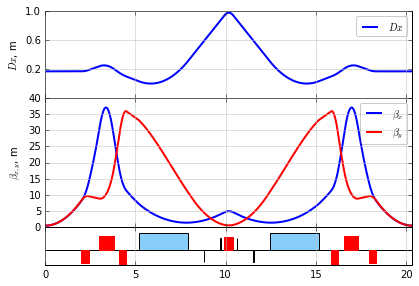

In [7]:
# plot twiss paramentrs.
plot_opt_func(lat, tws, legend=False, font_size=10)

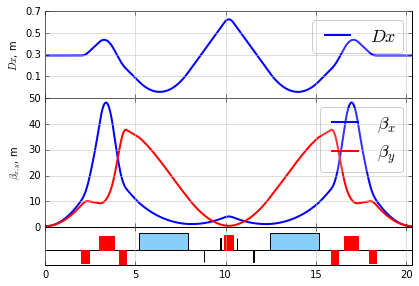

In [8]:
# you can play with quadrupole strength and try to make achromat
Q4.k1 = 1.5

# to make achromat uncomment next line
# Q4.k1 =  1.18543769836
# To use matching function, please see ocelot/demos/ebeam/dba.py 

# updating trransfer maps after changing element parameters. 
lat.update_transfer_maps()

# recalculate twiss parameters 
tws=twiss(lat, nPoints=1000)

plot_opt_func(lat, tws, legend=False)